
# Machine Learning Models for Cash Flow Prediction
In this notebook, we are developing and training a Random Forest and a Feedforward Neural Network to predict future cash flows.

**How Machine Learning Models Work in General**: 
The general gist is that models work by learning from training data and evaluating itself on testing data.

In machine learning, training data is used to teach a model how to make predictions. This data includes both input features and the correct outputs, allowing the model to learn patterns and relationships. In a simple example, you could give a model pictures of various colors and tell it, “this is red,” or “this is not red.” Once trained, the model can tell which picture is red.

In our unlevered free cash flows instance, if you’re training a model to predict future cash flows, you’d provide it with historical data on revenue, EBITDA, and other financial metrics along with actual cash flow outcomes. The model learns from this data to understand how these factors influence cash flow. (we got all of this data from before!)

After training, the model is evaluated using testing data, which consists of new, unseen examples. This step is crucial to check how well the model generalizes its learning to different data. For example, after training your cash flow model on historical financial data, you’d test it with data from other companies not included in the training set to see if it can accurately predict cash flows. This evaluation helps ensure that the model performs well beyond the specific examples it was trained on. 



1. **Data Preparation**: Four CSV files containing different financial datasets are loaded, merged, and preprocessed to handle missing values, encode categories, and remove non-numeric columns. 

2. **Winsorization and Scaling**: Winsorization is applied to reduce the effect of extreme values. Winsoirzation is essentially removing values that are below the fifth percentile in a range of data, and above the 95th percentile in a range of data. The features are also scaled to ensure better model performance.

3. **Model Training**: The data is split into training and testing sets, and both a Neural Network and a Random Forest model are trained. Hyperparameter tuning is performed to find the best parameters for each model. (RandomizedSearchCV)

### How Neural Networks Work:
Neural networks are like mimicking the human brain with layers of "neurons" that pass information forward. Each layer processes information and passes it to the next layer. The model adjusts itself to minimize errors, becoming better at predictions over time. It’s particularly useful when dealing with complex data and relationships.

### How Random Forests Work:
A Random Forest is like growing a bunch of decision trees that try to make predictions based on different subsets of the data. Each tree in the forest gives its opinion, and the final prediction is the average of all these trees’ results. This method helps prevent overfitting and makes solid predictions on structured data.

Additional Info - Please Read Below! 

My first iteration of my project, actually only involved a neural network where I would take the historical information of every UFCF formula component, as that was the information I collected in the previous notebook! The neural network would also take the data from the first spreadsheet, valuation metrics data, and financial statements from yfinance API. However, this original product didn't generalize well on new data after training, so I needed a different approach with different historical factors to feed into my model. (to strengthen its prediction capabilities) Luckily, the machine learning's library has a function called feature importance. I used this feature in my original neural network, to find that the most important features contributing to the machine learning model's (limited) success were EBITDA, Revenue, Gross Profit, and Net Working Capital, with the addition of two features from the financial statements I had also attached: 'Total Assets' and 'Gross Profit.' Using the historic financial data API that I used to get the historic data for every UFCF formula component, I also got historic information on the additional features that could make the model stronger --> 'Total Assets' and 'Gross Profits.'

In [ ]:
#api request with additional features based on importance scores
import requests
import pandas as pd

# Define the API key and base URL for EODHD
API_KEY = '66ccfb2e19c120.99231857'
BASE_URL = 'https://eodhd.com/api/fundamentals/'

# Define a function to fetch financial data for a single ticker
def fetch_financial_data(ticker, start_year=1980, end_year=2023):
    url = f"{BASE_URL}{ticker}?api_token={API_KEY}&fmt=json"
    
    # Make the API request
    response = requests.get(url)
    
    # Convert the response to JSON
    data = response.json()
    
    # Extract relevant financial data
    financial_data = []
    if 'Financials' in data and 'Income_Statement' in data['Financials']:
        income_statements = data['Financials']['Income_Statement']['yearly']
        balance_sheets = data['Financials']['Balance_Sheet']['yearly']
        cash_flows = data['Financials']['Cash_Flow']['yearly']
        market_cap = data.get('Highlights', {}).get('MarketCapitalization', None)

        for year, details in income_statements.items():
            # Extract the year from the date string
            year_int = int(year[:4])
            if start_year <= year_int <= end_year:
                # Check if the year exists in balance sheets and cash flow statements
                if year in balance_sheets and year in cash_flows:
                    # Extract data from income statements, balance sheets, and cash flow statements
                    free_cash_flow = cash_flows[year].get('freeCashFlow', None)
                    ebitda = details.get('ebitda', None)
                    gross_profit = details.get('grossProfit', None)  # Extract Gross Profit
                    net_working_capital = balance_sheets[year].get('netWorkingCapital', None)
                    total_assets = balance_sheets[year].get('totalAssets', None)  # Extract Total Assets

                    financial_data.append({
                        'Year': year_int,
                        'Ticker': ticker,
                        'Total Revenue': details.get('totalRevenue', None),
                        'EBITDA': ebitda,
                        'Gross Profit': gross_profit, #new!
                        'Net Working Capital': net_working_capital,
                        'Total Assets': total_assets, #new!
                        'Market Capitalization': market_cap
                    })
    
    return financial_data

# Load the CSV file containing tickers
tickers_df = pd.read_csv('AllDatav2.csv')  

# Assume the tickers are in a column named 'Ticker'
tickers = tickers_df['Ticker'].tolist()

# Fetch data for all tickers and compile into a DataFrame
all_financial_data = []
for ticker in tickers:
    financial_data = fetch_financial_data(ticker)
    all_financial_data.extend(financial_data)

# Convert to DataFrame
df_financial = pd.DataFrame(all_financial_data)

# Sort the DataFrame by Ticker and Year
df_financial = df_financial.sort_values(by=['Ticker', 'Year'])

# Save the DataFrame to a CSV file
df_financial.to_csv('historical_financial_data_eodhdsecondversion.csv', index=False)

# Display the DataFrame
print(df_financial)

2024-09-10 17:37:42.868618: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/var/folders/mf/zm3qz5852hs67j4m4hwml0z80000gn/T/ipykernel_70264/1392023761.py:18: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt  # For Keras-based hyperparameter optimization


Winsorizing Ebitda (Skewness: 4.050569804829762)
Winsorizing Depreciation/Amortization (Skewness: 7.667167007296864)
Winsorizing Net Working Capital Increase Per Year (Skewness: 6.9300906458696385)
Winsorizing UFCF (Skewness: 4.933928566278042)
Winsorizing Annual Recurring Revenue (ARR) (Skewness: 3.9721231284181635)
Winsorizing Monthly Recurring Revenue (MRR) (Skewness: 3.9721231284181635)
Winsorizing Gross Burn Rate (Skewness: 3.7192570723541554)
Winsorizing Sales Efficiency (Skewness: 1.5372585139682493)
Winsorizing Total Debt (Skewness: 7.146888876487228)
Winsorizing Enterprise Value (Skewness: 3.6147971388698616)
Winsorizing Preferred Stock Value (Skewness: 3.4069190633613777)
Winsorizing Enterprise Value/Revenue (Skewness: 3.9192942389160708)
Winsorizing Market Cap($) (Skewness: 3.3508798768202235)
Winsorizing Price (Skewness: 3.411034125858177)
Winsorizing Price to earnings (Skewness: 10.998266343081413)
Winsorizing Volume (Skewness: 8.187941741839715)
Winsorizing Avg Volume (Sk

/var/folders/mf/zm3qz5852hs67j4m4hwml0z80000gn/T/ipykernel_70264/1392023761.py:189: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = KerasRegressor(build_fn=create_model, verbose=0)
2024-09-10 17:39:59.888348: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-10 17:39:59.888349: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operation

[CV] END batch_size=16, dropout=0.4, epochs=50, learning_rate=0.001, neurons1=32, neurons2=64, neurons3=16; total time= 4.8min
[CV] END batch_size=16, dropout=0.3, epochs=100, learning_rate=0.01, neurons1=32, neurons2=64, neurons3=16; total time= 9.2min
[CV] END batch_size=16, dropout=0.3, epochs=100, learning_rate=0.01, neurons1=32, neurons2=64, neurons3=16; total time= 9.2min
[CV] END batch_size=16, dropout=0.4, epochs=50, learning_rate=0.001, neurons1=32, neurons2=64, neurons3=16; total time= 4.6min
[CV] END batch_size=16, dropout=0.3, epochs=100, learning_rate=0.01, neurons1=32, neurons2=64, neurons3=16; total time= 9.5min
[CV] END batch_size=32, dropout=0.2, epochs=30, learning_rate=0.01, neurons1=32, neurons2=16, neurons3=8; total time= 1.2min
[CV] END batch_size=32, dropout=0.2, epochs=30, learning_rate=0.01, neurons1=32, neurons2=16, neurons3=8; total time= 1.3min
[CV] END batch_size=32, dropout=0.2, epochs=30, learning_rate=0.01, neurons1=32, neurons2=16, neurons3=8; total tim

2024-09-10 18:15:35.015680: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Best Neural Network parameters: {'neurons3': 16, 'neurons2': 64, 'neurons1': 32, 'learning_rate': 0.01, 'epochs': 100, 'dropout': 0.3, 'batch_size': 16}
Best Neural Network RMSE: 116962174.04965013
Neural Network - Test RMSE: 67982579.89635345, R2: 0.9777947796634008


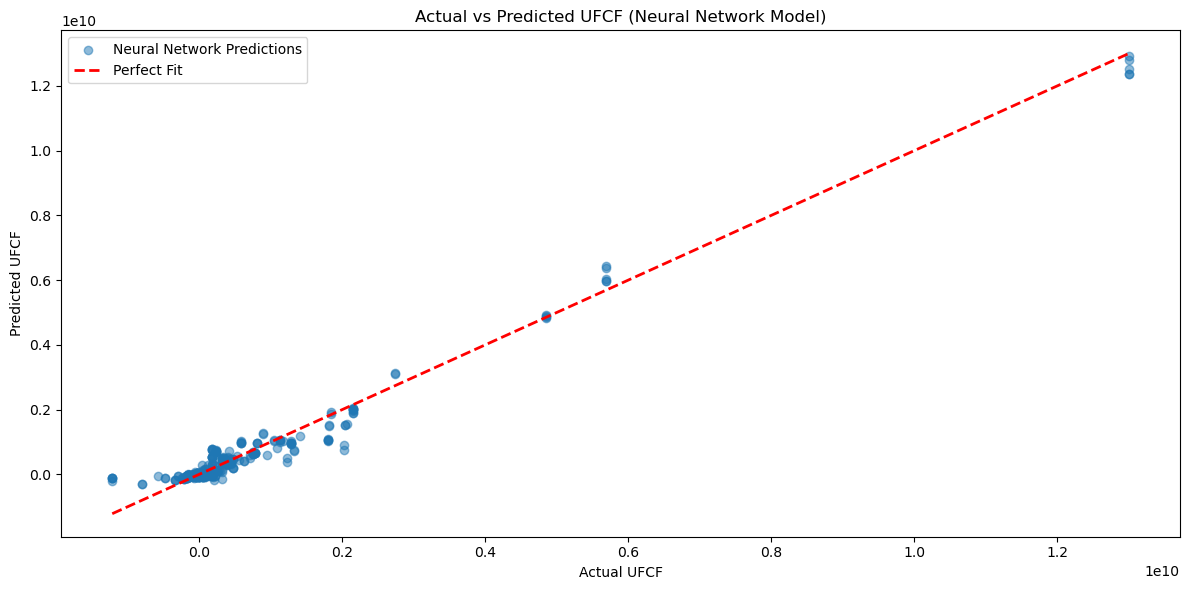

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END max_depth=14, min_samples_leaf=29, min_samples_split=33, n_estimators=124; total time=  14.9s
[CV] END max_depth=14, min_samples_leaf=29, min_samples_split=33, n_estimators=124; total time=  15.1s
[CV] END max_depth=14, min_samples_leaf=29, min_samples_split=33, n_estimators=124; total time=  15.2s
[CV] END max_depth=14, min_samples_leaf=29, min_samples_split=33, n_estimators=124; total time=  15.2s
[CV] END max_depth=14, min_samples_leaf=29, min_samples_split=33, n_estimators=124; total time=  15.8s
[CV] END max_depth=27, min_samples_leaf=5, min_samples_split=45, n_estimators=231; total time=  38.2s
[CV] END max_depth=27, min_samples_leaf=5, min_samples_split=45, n_estimators=231; total time=  38.5s
[CV] END max_depth=27, min_samples_leaf=5, min_samples_split=45, n_estimators=231; total time=  38.8s
[CV] END max_depth=27, min_samples_leaf=5, min_samples_split=45, n_estimators=231; total time=  38.2s
[CV] END max_de

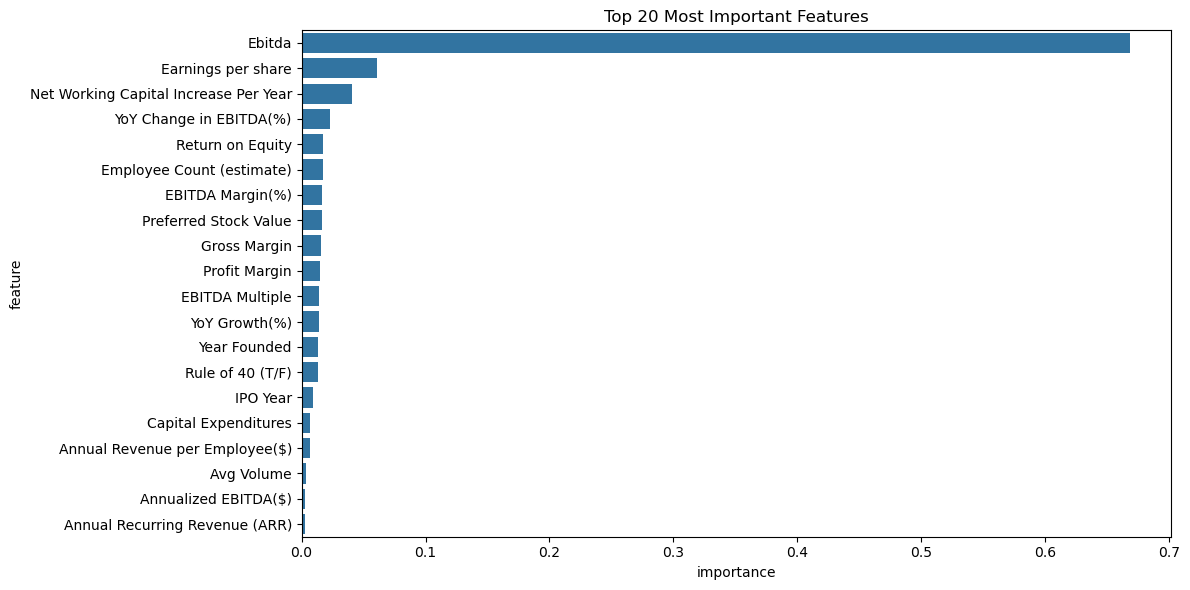

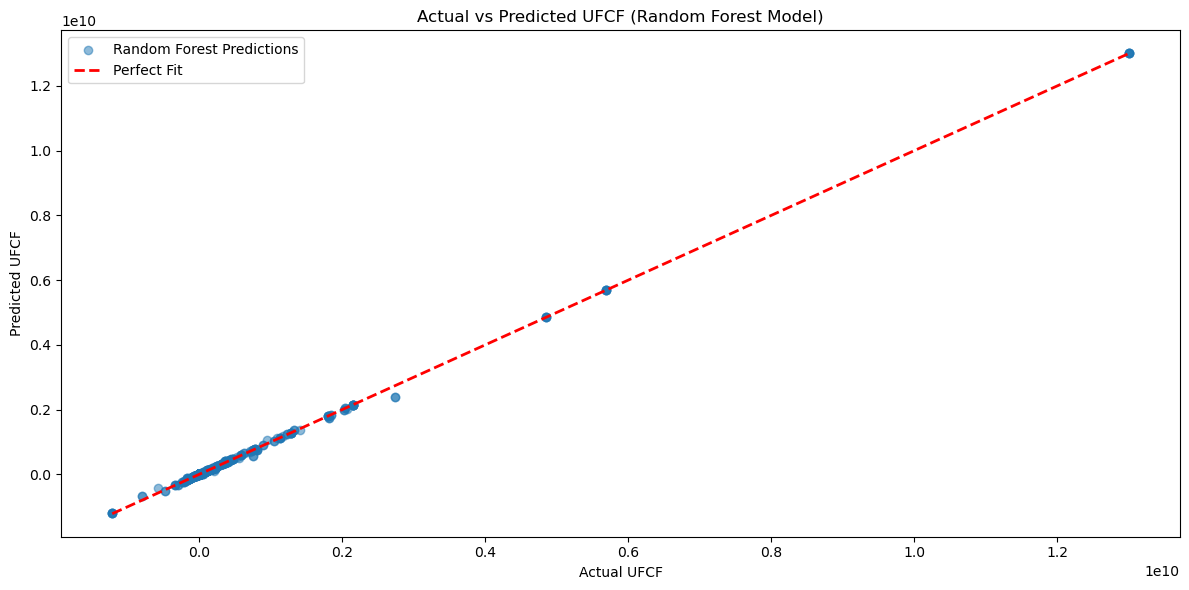

Models, scalers, and transformations saved successfully.


In [1]:
import pandas as pd  # For data manipulation and analysis
import numpy as np  # For numerical operations
from scipy.stats.mstats import winsorize  # For handling outliers via winsorization
from sklearn.model_selection import train_test_split, RandomizedSearchCV  # For splitting the data and hyperparameter tuning
from sklearn.preprocessing import PowerTransformer, RobustScaler, LabelEncoder, StandardScaler  # For feature scaling and encoding
from sklearn.metrics import mean_squared_error, r2_score  # For evaluating model performance
from sklearn.ensemble import RandomForestRegressor  # For using Random Forest in regression tasks
import tensorflow as tf  # Deep learning framework
from tensorflow.keras.models import Sequential  # Sequential model API for building the neural network
from tensorflow.keras.layers import Dense, Dropout  # Layers for the neural network
from tensorflow.keras.optimizers import Adam  # Optimizer for the neural network
from joblib import dump, load  # For saving and loading models
import yfinance as yf  # For fetching financial data from Yahoo Finance
import matplotlib.pyplot as plt  # For data visualization
import seaborn as sns  # For advanced visualizations
import pickle  # For saving Python objects (scalers, transformers, etc.)
from scipy.stats import randint  # For random number generation (used in hyperparameter tuning)
import kerastuner as kt  # For Keras-based hyperparameter optimization
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor  # Wrapper for Keras model to be used in scikit-learn

# Time to load up our data! We've got different CSV files for various aspects of our analysis
valuation_metrics_path = 'valuation_metrics_official.csv' #our valuation metrics!
processed_data_path = 'processed_data_ml3.csv' #our UFCF factors from the formula! (non-historic)
additional_data_path = 'AllDatav2.csv' #additional information!
historic_data_path = 'historical_financial_data_eodhdsecondversion.csv' #historic information from the detailed financial API!

# Reading all those CSVs into DataFrames. 
valuation_metrics_df = pd.read_csv(valuation_metrics_path)
processed_data_df = pd.read_csv(processed_data_path)
additional_data_df = pd.read_csv(additional_data_path)
historic_data_df = pd.read_csv(historic_data_path)

# Filling NaNs with zeros right off the bat. 
valuation_metrics_df = valuation_metrics_df.fillna(0)
processed_data_df = processed_data_df.fillna(0)
additional_data_df = additional_data_df.fillna(0)
historic_data_df = historic_data_df.fillna(0)


le = LabelEncoder()
processed_data_df['Ticker'] = le.fit_transform(processed_data_df['Ticker'])
valuation_metrics_df['Ticker'] = le.transform(valuation_metrics_df['Ticker'])
additional_data_df['Ticker'] = le.transform(additional_data_df['Ticker'])
historic_data_df['Ticker'] = le.transform(historic_data_df['Ticker'])

#encode EVERY ticker so that the model can differentiate between them. Remember, models can't evaluate human language or text, so encoding enumerates each ticker.

# Saving our encoder for later. 
dump(le, 'label_encoderrf.joblib')

# Kicking out the 'Year' column. 
columns_to_drop = ['Year']
processed_data_df = processed_data_df.drop(columns=columns_to_drop)

#only numeric columns
additional_data_df = additional_data_df.select_dtypes(include=[np.number])

# Time for the big data merge! 
data_df = pd.merge(processed_data_df, valuation_metrics_df, on='Ticker', how='left')
data_df = pd.merge(data_df, additional_data_df, on='Ticker', how='left')
data_df = pd.merge(data_df, historic_data_df, on=['Ticker'], how='left')

# One more round of NaN-zapping. 
data_df = data_df.fillna(0)

# Keeping it numeric
data_df = data_df.select_dtypes(include=[np.number])

# This function will help us deal with skewed data. 
def winsorize_features(df, skew_threshold=1):
    winsorized_df = df.copy()
    for column in df.columns:
        skewness = df[column].skew()
        if skewness > skew_threshold:
            print(f"Winsorizing {column} (Skewness: {skewness})")
            winsorized_df[column] = winsorize(df[column], limits=[0.01, 0.01]) #values are clipped in the bottom 1 percent and top 1 percent
    return winsorized_df

# Apply our winsorizing to columns with skewness over 1
data_df = winsorize_features(data_df)

# This function grabs even more financial data using yfinance. --> basically all the financial statements
def fetch_financial_data(ticker):
    stock = yf.Ticker(ticker)
    financials = stock.financials
    balance_sheet = stock.balance_sheet
    cashflow = stock.cashflow
    
    combined_df = pd.concat([financials, balance_sheet, cashflow], axis=0)
    
    # Flip it and reverse it (transpose the DataFrame)
    combined_df = combined_df.T
    
    # Giving each column a unique name to avoid mix-ups
    combined_df.columns = [f"{ticker}_{col}" for col in combined_df.columns]
    
    return combined_df

# Fetch and integrate data 
financial_features_list = [fetch_financial_data(ticker) for ticker in le.classes_]
financial_features_df = pd.concat(financial_features_list, axis=1).T.reset_index(drop=True)
data_df = pd.concat([data_df.reset_index(drop=True), financial_features_df], axis=1)
data_df = data_df.select_dtypes(include=[np.number])

#ALL of our data is now merged for the model to read, train, test, and evaluate itself on.

# Splitting our data into features (X) and target (y). UFCF is our golden ticket!
X = data_df.drop(columns=['UFCF'])
y = data_df['UFCF']

# One last NaN check. 
X = X.fillna(0)
y = y.fillna(0)

# This function fills NaNs with median values. It's like finding the middle ground for missing data
def handle_nans(df):
    df_filled = df.copy()
    for column in df.columns:
        median_value = df[column].median()
        df_filled[column] = df_filled[column].fillna(median_value)
    return df_filled

# These dictionaries will store our transformers and scalers. 
pt_dict = {}
scaler_dict = {}

# This function applies different transformations based on the skewness of the data
def transform_features(df):
    transformed_df = df.copy()
    for column in df.columns:
        skewness = df[column].skew()
        
        if skewness > 0.5 or skewness < -0.5:
            print(f"Yeo-Johnson transforming {column} (Skewness: {skewness})") #Yeo-Johnson transformation is a method to make data more normal (symmetrically distributed)
            pt = PowerTransformer(method='yeo-johnson')
            transformed_df[column] = pt.fit_transform(df[[column]])
            pt_dict[column] = pt  # Save the transformer for this column
        else:
            print(f"Applying RobustScaler to {column} (Skewness: {skewness})") # RobustScaler scales data based on the median and the interquartile range (IQR), only applied to non-skewed columns
            scaler = RobustScaler() #RobustScaler subtracts the median and divides by the IQR (the range between the 25th and 75th percentiles)
            transformed_df[column] = scaler.fit_transform(df[[column]])
            scaler_dict[column] = scaler  # Save the scaler for this column
    
    return transformed_df

# Time to handle those pesky NaNs
X = handle_nans(X)

# Apply our transformations. 
X_transformed = transform_features(X)

# One more NaN check. 
X_transformed = X_transformed.fillna(0)

# Split the data into training and testing sets. 
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=42)

# StandardScaler scales data by subtracting the mean and dividing by the standard deviation, has a mean of 0 and standard devaition of 1 for consistency
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# This function creates our neural network model. 
def create_model(neurons1=64, neurons2=32, neurons3=16, dropout=0.3, learning_rate=0.001):
    model = Sequential()
    model.add(Dense(neurons1, activation='relu', input_shape=(X_train.shape[1],))) 
    model.add(Dropout(dropout)) #add dropout to avoid overfitting, by dropping a neuron
    model.add(Dense(neurons2, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(neurons3, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model

# Wrap our Keras model in a KerasRegressor --> so we can use the trained model later to make predictions
keras_reg = KerasRegressor(build_fn=create_model, verbose=0)

# Define the hyperparameter search space. We're giving our model some options to choose from
param_dist_nn = {
    'neurons1': [32, 64, 128],
    'neurons2': [16, 32, 64],
    'neurons3': [8, 16, 32],
    'dropout': [0.2, 0.3, 0.4],
    'learning_rate': [0.001, 0.01],
    'batch_size': [16, 32],
    'epochs': [30, 50, 100]
}

# Time for some hyperparameter tuning! It's like finding the perfect recipe for our model
nn_random_search = RandomizedSearchCV(estimator=keras_reg, param_distributions=param_dist_nn, 
                                      n_iter=10, cv=3, verbose=2, n_jobs=-1)

# Run the randomized search. Our model is going to search for the best parameters!
nn_random_search_result = nn_random_search.fit(X_train_scaled, y_train)

print("Best Neural Network parameters:", nn_random_search_result.best_params_)
print("Best Neural Network RMSE:", np.sqrt(-nn_random_search_result.best_score_))

# Train the best Neural Network model with the winning parameters
best_nn_model = nn_random_search_result.best_estimator_
best_nn_model.fit(X_train_scaled, y_train)

# Time to see how well our Neural Network performs!
nn_pred = best_nn_model.predict(X_test_scaled)
nn_rmse = np.sqrt(mean_squared_error(y_test, nn_pred))
nn_r2 = r2_score(y_test, nn_pred)
print(f"Neural Network - Test RMSE: {nn_rmse}, R2: {nn_r2}")

# Let's visualize how well our Neural Network did with a scatter plot
plt.figure(figsize=(12, 6))
plt.scatter(y_test, nn_pred, alpha=0.5, label='Neural Network Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Fit')
plt.xlabel('Actual UFCF')
plt.ylabel('Predicted UFCF')
plt.title('Actual vs Predicted UFCF (Neural Network Model)')
plt.legend()
plt.tight_layout()
plt.show()

# Save our fantastic Neural Network model for later use
best_nn_model.model.save('best_nn_model6.h5')

# Now let's tune our Random Forest model. It's like fine-tuning a musical instrument!
rf_model = RandomForestRegressor(random_state=42)
rf_param_dist = {
    'n_estimators': randint(100, 450),
    'max_depth': randint(5, 40),
    'min_samples_split': randint(2, 50),
    'min_samples_leaf': randint(1, 40)
}

rf_random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=rf_param_dist,
                                      n_iter=20, cv=5, verbose=2, n_jobs=-1, scoring='neg_mean_squared_error')
rf_random_search_result = rf_random_search.fit(X_train, y_train)

print("Best Random Forest parameters:", rf_random_search_result.best_params_)
print("Best Random Forest RMSE:", np.sqrt(-rf_random_search_result.best_score_))

# Train the best Random Forest model. It's forest-growing time!
best_rf = RandomForestRegressor(**rf_random_search_result.best_params_, random_state=42)
best_rf.fit(X_train, y_train)

# Let's see how our Random Forest performs on the test set
rf_pred = best_rf.predict(X_test)

# Calculate RMSE and R2 for Random Forest. Time to grade our forest!
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
rf_r2 = r2_score(y_test, rf_pred)
print(f"Random Forest - Test RMSE: {rf_rmse}, R2: {rf_r2}")

# Let's check out which features are the most important to our model
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_rf.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(20))
plt.title('Top 20 Most Important Features')
plt.tight_layout()
plt.show()

# One more scatter plot to visualize our Random Forest predictions
plt.figure(figsize=(12, 6))
plt.scatter(y_test, rf_pred, alpha=0.5, label='Random Forest Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Fit')
plt.xlabel('Actual UFCF')
plt.ylabel('Predicted UFCF')
plt.title('Actual vs Predicted UFCF (Random Forest Model)')
plt.legend()
plt.tight_layout()
plt.show()

# Time to save our  Random Forest model!
dump(best_rf, 'best_rf_model6.joblib')

#save our scalers and transformers.
dump(scaler, 'standard_scaler6.joblib')
with open('pt_dict6.pkl', 'wb') as f:
    pickle.dump(pt_dict, f)
with open('scaler_dict6.pkl', 'wb') as f:
    pickle.dump(scaler_dict, f)

#Yay!!!
print("Models, scalers, and transformations saved successfully.")

The Root Mean Square Error (RMSE) is a metric that measures the difference between predicted and actual values. A lower RMSE indicates a more accurate model.
The Best RMSE here refers to how the model performed during training or cross-validation. It’s a gauge of how well the model fit the training data.
This is the RMSE calculated on the test set, which the model has not seen before. It provides an indication of how well the model generalizes to unseen data.
The R² score, or coefficient of determination, is a metric that indicates the proportion of variance in the target variable that is explained by the model. It ranges from 0 to 1, with 1 indicating a perfect fit.

Based on the results, both the neural network and random forest models performed well, but there’s a notable difference in their accuracy.

The neural network model showed solid performance, with a test RMSE of about 67.98 million and an R² score of 0.978. This means it explained approximately 97.8% of the variance in the data. The model used 3 layers of neurons (16, 64, and 32), had a learning rate of 0.01, and applied a dropout rate of 0.3 to mitigate overfitting. It was trained for 100 epochs with a batch size of 16. While the neural network captured trends effectively, the RMSE suggests that predictions weren't perfectly precise, though the model managed to grasp the underlying patterns reasonably well.

In contrast, the random forest model outperformed the neural network significantly. It achieved a test RMSE of just 9.17 million and an outstanding R² score of 0.9996, meaning it explained nearly 100% of the variance in the test data. The optimal parameters for the random forest included a maximum depth of 28, a minimum samples split of 17, and 218 estimators (trees). This model’s superior accuracy likely stems from its strength in managing structured, tabular data and capturing complex non-linear relationships, which made it more effective for this dataset.

It's important to note that each Ticker (Company) was evaluated by the models, and the error margins represent an average across all 170+ tickers. That means, based on the amount of historic information available for each company, the model performed better or worse in predicting their UFCF values.

In summary, while the neural network performed admirably, the random forest was the standout performer, delivering far more accurate and consistent predictions. It’s not uncommon for random forests to outperform neural networks on structured tabular datasets like this one. Both RMSEs for each model are impressive when put next to the fact that it has million dollar errors in the context of multi billion dollar values.

Additionally, we can see the various features that contribute to the machine learning models' impressive performances through the top 20 features chart.

Before, we can use the saved models to make predictions, we need to get some more data. This is because saved models such as our neural network and random forest, need the exact same format of information used to initially train the models. However, to make predictions, we need to ensure that we have new and future values of our (previously) historic features. We can use a polynomial regression model to observe simple trends within these historic data points, and predict new values. Then, we can use these new predicted values and create UFCF predictions with our saved deep learning models.